In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T

from huggingface_hub import notebook_login

from datasets import load_dataset

from transformers import AutoImageProcessor, ViTForImageClassification

from transformers import Trainer, TrainingArguments

import evaluate

In [2]:
notebook_login()

Token has not been saved to git credential helper.


In [ ]:
import zipfile

with zipfile.ZipFile("daten.zip", "r") as zip_ref:
    zip_ref.extractall("daten")

In [2]:
dataset = load_dataset("imagefolder", data_dir="daten")
dataset

Resolving data files:   0%|          | 0/3115 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/351 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/359 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3115
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 351
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 359
    })
})

In [3]:
labels = dataset["train"].features["label"].names
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for i, label in enumerate(labels)}

In [5]:
print(len(labels),labels)

36 ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [4]:
processor = AutoImageProcessor.from_pretrained('google/vit-base-patch16-224')
processor

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

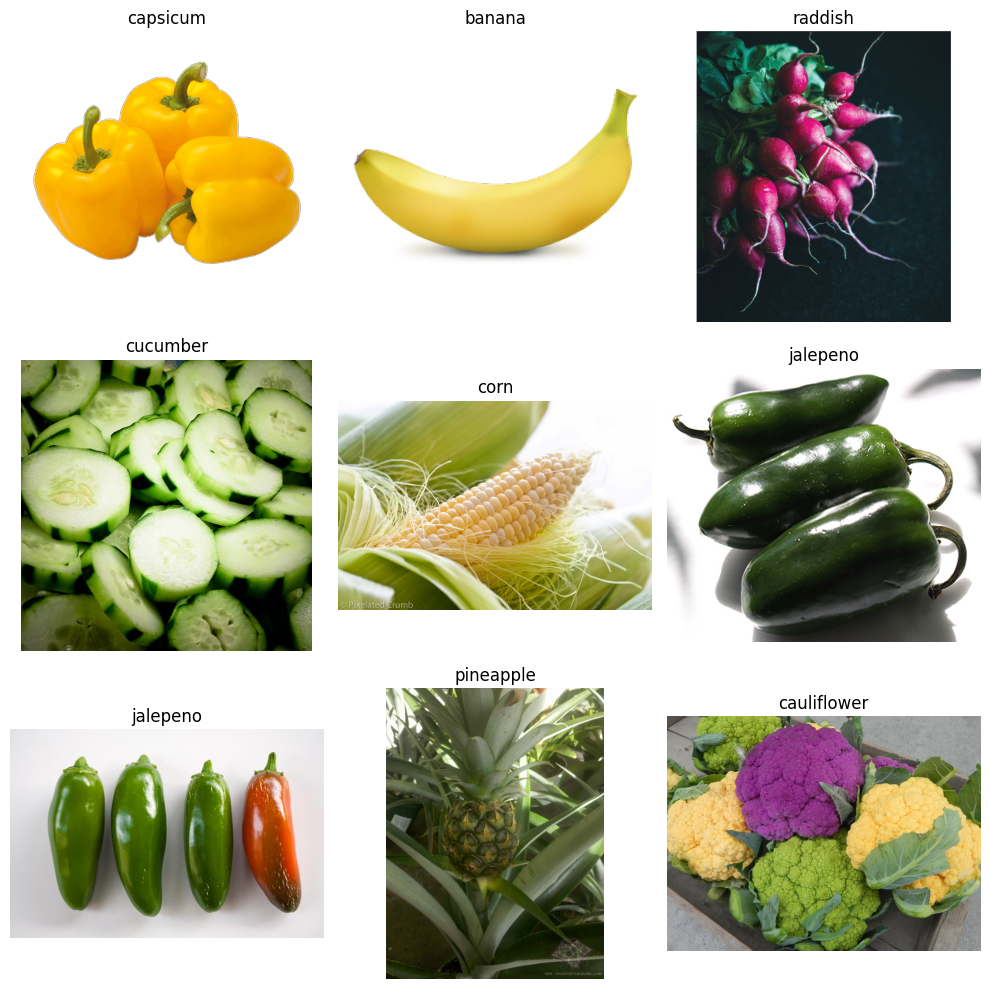

In [9]:
samples = dataset["train"].shuffle(seed=42).select(range(9))

plt.figure(figsize=(10, 10))
for i, sample in enumerate(samples):
    image = sample["image"]
    label = sample["label"]
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(id2label[label])
    plt.axis("off")

plt.tight_layout()
plt.show()

In [8]:
train_augmentations = T.Compose([
    T.RandomPerspective(distortion_scale=0.5, p=0.5),
    T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.RandomRotation(30),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    T.RandomAffine(degrees=30, translate=(0.1, 0.1))
])

In [11]:
def train_transforms(batch):
    batch['image'] = [train_augmentations(x.convert('RGB')) for x in batch['image']]
    inputs = processor(batch['image'], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

def transforms(batch):
    batch['image'] = [x.convert('RGB') for x in batch['image']]
    inputs = processor(batch['image'], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

In [12]:
processed_dataset = {
    "train": dataset["train"].with_transform(train_transforms),
    "validation": dataset["validation"].with_transform(transforms),
    "test": dataset["test"].with_transform(transforms)
}

In [13]:
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [14]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=1)
    score = accuracy.compute(predictions=predictions, references=labels)
    return score

In [15]:
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([36]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([36, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

In [16]:
for name, param in model.named_parameters():
    if not name.startswith("classifier"):
        param.requires_grad = False

In [17]:
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"{num_params = :,} | {trainable_params = :,}")

num_params = 85,826,340 | trainable_params = 27,684


In [18]:
training_args = TrainingArguments(
    output_dir="./fruits-and-vegetables-vit",
    per_device_train_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    num_train_epochs=5,
    learning_rate=3e-4,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=True,
    report_to='tensorboard',
    load_best_model_at_end=True,
    run_name="transferlearning-google_vit-base-patch16-224 with data augmentation"
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["validation"],
    tokenizer=processor
)

/tmp/ipykernel_3383/613752247.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [5]:
from PIL import Image
from PIL import ImageFile
import os
from pathlib import Path

ImageFile.LOAD_TRUNCATED_IMAGES = True

def check_images_in_directory(directory):
    # Überprüfen, ob das Verzeichnis existiert
    directory = Path(directory)
    
    if not directory.exists():
        print(f"Das Verzeichnis {directory} wurde nicht gefunden!")
        return

    # Durchläuft alle Dateien und Unterordner im angegebenen Verzeichnis
    for file_path in directory.rglob("*"):  # rglob geht rekursiv durch alle Unterordner
        if file_path.suffix in [".jpg", ".png"]:  # Überprüft, ob es eine .jpg oder .png Datei ist
            try:
                img = Image.open(file_path)
                img.verify()  # Überprüft, ob das Bild gültig ist
            except (IOError, SyntaxError) as e:
                print(f"Fehler beim Laden des Bildes: {file_path}")

# Beispielverzeichnis auf lightning.ai (Anpassen je nach Speicherort)
check_images_in_directory("daten")

In [23]:
trainer.train()

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


TrainOutput(global_step=975, training_loss=0.9650162290915465, metrics={'train_runtime': 3780.9835, 'train_samples_per_second': 4.119, 'train_steps_per_second': 0.258, 'total_flos': 1.299084004840366e+18, 'train_loss': 0.9650162290915465, 'epoch': 5.0})

In [24]:
trainer.evaluate(processed_dataset['test'])

{'eval_loss': 0.25982797145843506,
 'eval_accuracy': 0.9164345403899722,
 'eval_runtime': 24.234,
 'eval_samples_per_second': 14.814,
 'eval_steps_per_second': 1.857,
 'epoch': 5.0}

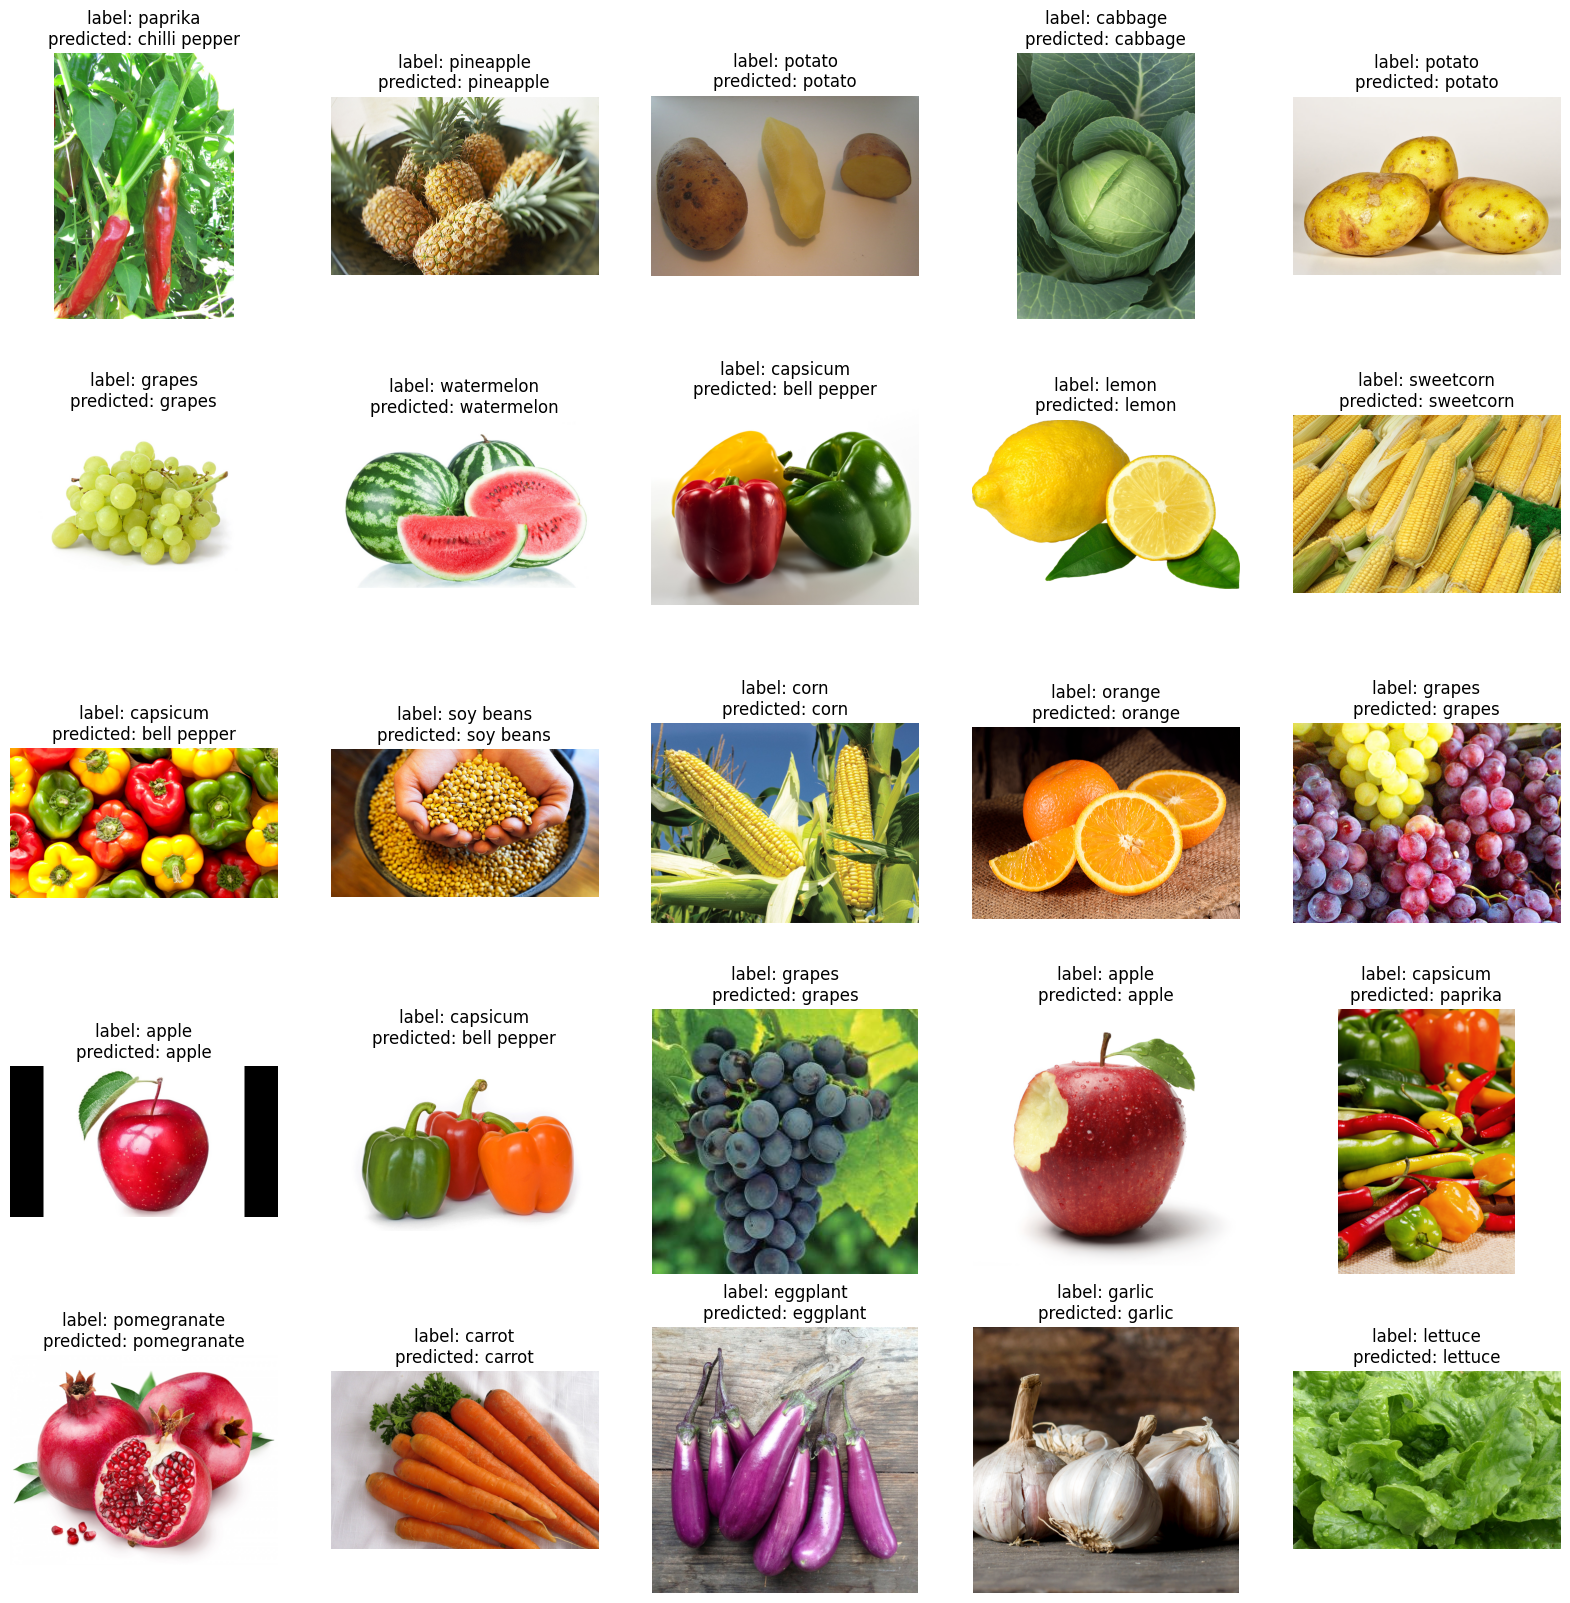

In [25]:
def show_predictions(rows, cols):
    samples = dataset['test'].shuffle().select(np.arange(rows * cols))
    processed_samples = samples.with_transform(transforms)
    predictions = trainer.predict(processed_samples).predictions.argmax(axis=1)

    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(rows * cols):
        img = samples[i]['image']
        true_label_name = id2label[samples[i]['label']]
        prediction = predictions[i]
        predicted_label_name = id2label[prediction]
        label = f"label: {true_label_name}\npredicted: {predicted_label_name}"
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(label)
        plt.axis('off')

show_predictions(rows=5,cols=5)

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "dataset": "fruits-and-vegetables-classification",
    "tasks": "image-classification",
    "tags": ["image-classification", "fruits", "vegetables", "food"]
}

trainer.save_model()
trainer.push_to_hub("fruits-and-vegetables-vit", **kwargs)

events.out.tfevents.1747296443.ip-10-192-12-251.3383.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ElioBaserga/fruits-and-vegetables-vit/commit/7591403b800b47f09eff6b8a32844fa6a32765fc', commit_message='fruits-and-vegetables-vit', commit_description='', oid='7591403b800b47f09eff6b8a32844fa6a32765fc', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ElioBaserga/fruits-and-vegetables-vit', endpoint='https://huggingface.co', repo_type='model', repo_id='ElioBaserga/fruits-and-vegetables-vit'), pr_revision=None, pr_num=None)

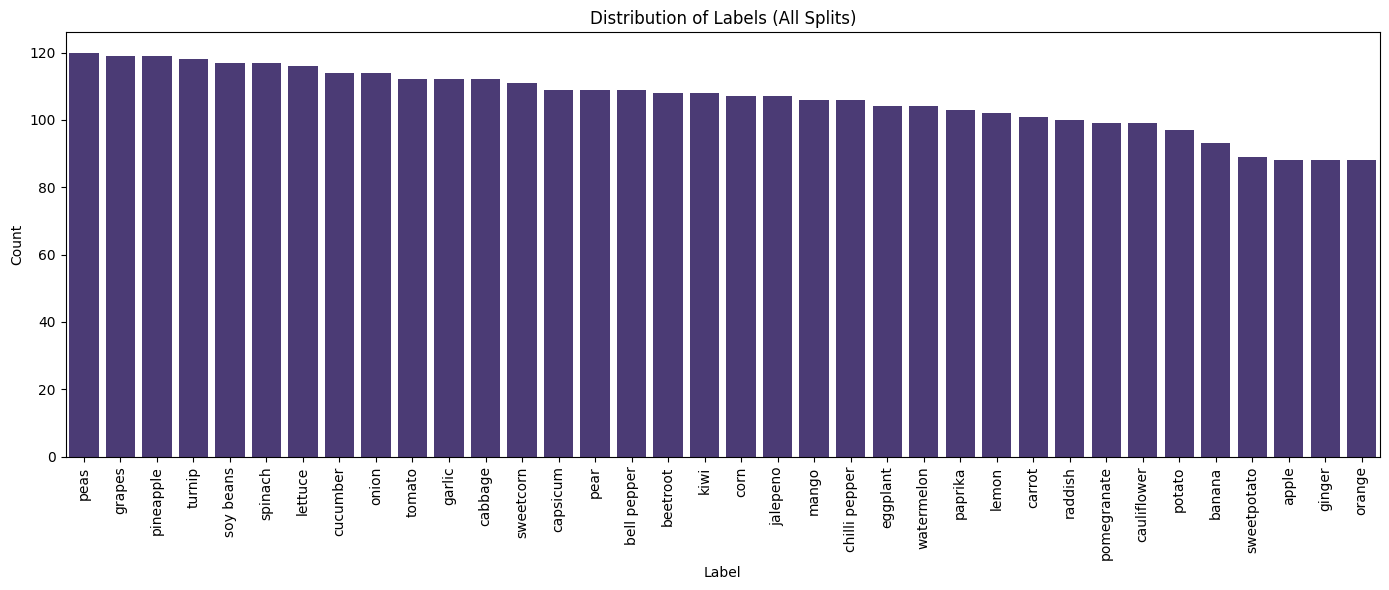

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_palette("viridis")

df_train = pd.DataFrame(dataset["train"])
df_train["split"] = "train"

df_val = pd.DataFrame(dataset["validation"])
df_val["split"] = "validation"

df_test = pd.DataFrame(dataset["test"])
df_test["split"] = "test"

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

if "label" in df_all.columns and "id2label" in globals():
    df_all["label"] = df_all["label"].map(id2label)

plt.figure(figsize=(14, 6))
sns.countplot(data=df_all, x='label', order=df_all['label'].value_counts().index)
plt.title("Distribution of Labels (All Splits)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

/tmp/ipykernel_16358/1924567483.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_all, x='isFrucht', palette="pastel")


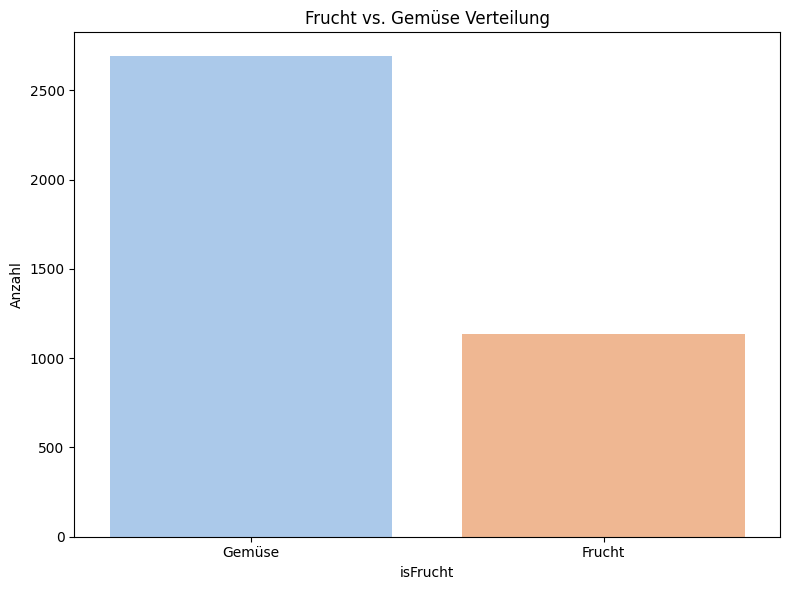

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_train = pd.DataFrame(dataset["train"])
df_val = pd.DataFrame(dataset["validation"])
df_test = pd.DataFrame(dataset["test"])

df_all = pd.concat([df_train, df_val, df_test], ignore_index=True)

if "label" in df_all.columns and "id2label" in globals():
    df_all["label_name"] = df_all["label"].map(id2label)
else:
    df_all["label_name"] = df_all["label"]

fruits = ["apple", "banana", "grapes", "kiwi", "lemon", "mango", "orange", "pear", "pineapple", "pomegranate", "watermelon"]

df_all["isFrucht"] = df_all["label_name"].apply(lambda x: 1 if x.lower() in fruits else 0)

plt.figure(figsize=(8, 6))
sns.countplot(data=df_all, x='isFrucht', palette="pastel")
plt.title("Frucht vs. Gemüse Verteilung")
plt.ylabel("Anzahl")
plt.xticks([0, 1], ['Gemüse', 'Frucht'])
plt.tight_layout()
plt.show()